In [92]:
%matplotlib inline
from tqdm import tqdm
from keras.datasets import mnist
import numpy as np
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, UpSampling2D, Convolution2D, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing import image
import keras.backend as K

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

11493376/11490434 [==============================] - 9s 1us/step


(60000, 28, 28)

In [5]:
n = len(X_train)

In [7]:
X_train = X_train.reshape(n, -1).astype(np. float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [8]:
X_train /= 255
X_test /= 255

In [9]:
X_train.shape

(60000, 784)

In [11]:
def noise(bs): return np.random.rand(bs, 100)

In [12]:
def data_D(sz, G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X, [0]*sz + [1]*sz

In [13]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

In [14]:
def train(D, G, m, nb_epoch=5000, bs=128):
    dl,gl=[],[]
    for e in tqdm(range(nb_epoch)):
        X,y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X,y))
        make_trainable(D, False)
        gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))
        make_trainable(D, True)
    return dl,gl

In [17]:
MLP_G = Sequential([
    Dense(200, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(784, activation='sigmoid'),
])

In [20]:
MLP_D = Sequential([
    Dense(300, input_shape=(784,), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid'),
])
MLP_D.compile(Adam(1e-4), "binary_crossentropy")

In [21]:
MLP_m = Sequential([MLP_G,MLP_D])
MLP_m.compile(Adam(1e-4), "binary_crossentropy")

In [22]:
dl,gl = train(MLP_D, MLP_G, MLP_m, 8000)

  0%|          | 0/8000 [00:00<?, ?it/s]/usr/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 8000/8000 [01:05<00:00, 122.38it/s]


In [26]:
res = MLP_G.predict(noise(16)).reshape(16, 28,28)

In [27]:
res.shape

(16, 28, 28)

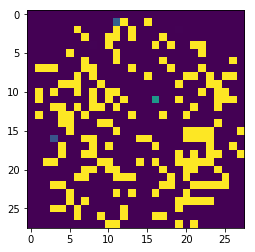

In [34]:
im = res[0]
plt.imshow(im)

In [66]:
img = Image.open('0-sign-clipart-7.jpg').convert('LA')
img = img.resize((10,10), Image.ANTIALIAS)

In [67]:
im = image.img_to_array(img)

In [68]:
im = im[:,:,0]
im = np.expand_dims(im, axis = 0)

In [69]:
print(noise(16).shape)
print(im.shape)
print(im.reshape(1, -1).shape)
res = MLP_G.predict(im.reshape(1, -1)).reshape(1, 28,28)

(16, 100)
(1, 10, 10)
(1, 100)


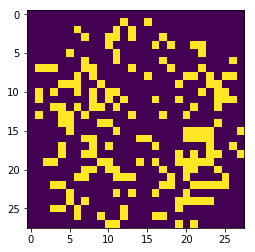

In [71]:
res.shape
im = res[0]
plt.imshow(im)

In [72]:
X_train = X_train.reshape(n, 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

In [85]:
CNN_G = Sequential([
    Dense(512*7*7, input_dim=100, activation=LeakyReLU()),
    BatchNormalization(),
    Reshape((7, 7, 512)),
    UpSampling2D(),
    Convolution2D(64, 3, 3, border_mode='same', activation=LeakyReLU()),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(32, 3, 3, border_mode='same', activation=LeakyReLU()),
    BatchNormalization(),
    Convolution2D(1, 1, 1, border_mode='same', activation='sigmoid')
])

/usr/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation=<keras.lay..., padding="same")`
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation=<keras.lay..., padding="same")`
  if __name__ == '__main__':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), activation="sigmoid", padding="same")`
  # This is added back by InteractiveShellApp.init_path()


In [88]:
CNN_D = Sequential([
    Convolution2D(256, 5, 5, subsample=(2,2), border_mode='same', 
                  input_shape=(28, 28, 1), activation=LeakyReLU()),
    Convolution2D(512, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU()),
    Flatten(),
    Dense(256, activation=LeakyReLU()),
    Dense(1, activation = 'sigmoid')
])

CNN_D.compile(Adam(1e-3), "binary_crossentropy")

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), input_shape=(28, 28, 1..., activation=<keras.lay..., strides=(2, 2), padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), activation=<keras.lay..., strides=(2, 2), padding="same")`
  after removing the cwd from sys.path.


In [89]:
sz = n//200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=128, nb_epoch=1, verbose=2)

/usr/lib/python3.6/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
 - 1s - loss: 0.7666


In [90]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-4), "binary_crossentropy")

In [93]:
K.set_value(CNN_D.optimizer.lr, 1e-3)
K.set_value(CNN_m.optimizer.lr, 1e-3)

In [94]:
dl,gl = train(CNN_D, CNN_G, CNN_m, 2500)


  0%|          | 0/2500 [00:00<?, ?it/s]/usr/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 2500/2500 [10:23<00:00,  4.01it/s]


In [106]:
res = CNN_G.predict(im.).reshape(16, 28,28)

SyntaxError: invalid syntax (<ipython-input-106-3f2ded6906a0>, line 1)

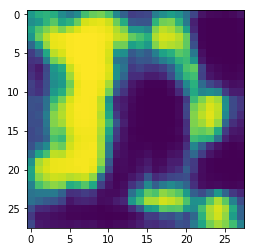

In [104]:
im = res[0]
plt.imshow(im)